## Install Dependencies

In [ ]:
!pip install optuna
!pip install -U kaleido
!torch torchvision trans
!pip install tensorflow

## Mount Google Drive

This assumes that the `src` directory has been uploaded to google drive with the following script:

* `torch_data_loader.py`

* `torch_encoder_decoder.py`

* `torch_hpo.py`

* `custom_utils.py`

In [28]:
%reload_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/cv_project/src')

from torch_hpo import objective, create_study
from custom_utils import get_logger, plot_hpo
from torch_data_loader import data_loader
from torch_encoder_decoder import Trainer, CaptionModel

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [32]:
import os
from typing import List, Tuple, Callable, Union, Dict, Any, Optional
import logging
import multiprocessing
import random

import torch
import torch.nn as nn
from torchvision import transforms

import optuna
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

### Global Constants & Set Up

In [4]:
batch_size = 32
pin_memory = True
shuffle = True
cpus = multiprocessing.cpu_count()
print(f'Number of cpus:', cpus)

Number of cpus: 4


In [5]:
logger = get_logger(name='torch-cnn-lstm-hpo')

## Load Data

We assume that the data is uploaded to google drive with the following directory structure:

```
data
└── images
    ├── test
    ├── train
    └── val
├── test_captions.txt
├── train_captions.txt
└── val_captions.txt
```

The subdirectories under `images` contain the `jpg` image files. First, we unzip the compressed file into the local system for use:

In [6]:
data_path = '/content/drive/MyDrive/cv_project/data'

In [ ]:
!unzip {data_path}/data.zip -d {data_path}

In [7]:
!ls {data_path}

images	test_captions.txt  train_captions.txt  val_captions.txt


First, we create a transformation pipeline that prepares the data for modeling, including resizing, converting to tensor, and normalization.

In [8]:
transform_pipeline = transforms.Compose([
    # Size expected by the Inception V3 pre-trained model
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Create the dataloader and custom datasets:

* Use multiprocessing to load the data

* Automatically put the fetched data Tensors in pinned memory, and enable faster data transfer to CUDA-enabled GPUs

In [9]:
train_loader, train_dataset = data_loader(
    image_dir=os.path.join(data_path, 'images/train'),
    captions_file=os.path.join(data_path, 'train_captions.txt'),
    transform=transform_pipeline,
    batch_size=batch_size,
    num_workers=cpus,
    shuffle=shuffle,
    pin_memory=pin_memory,
    test_mode=False
)

val_loader, val_dataset = data_loader(
    image_dir=os.path.join(data_path, 'images/val'),
    captions_file=os.path.join(data_path, 'val_captions.txt'),
    transform=transform_pipeline,
    batch_size=batch_size,
    num_workers=cpus,
    shuffle=False,
    pin_memory=pin_memory,
    test_mode=False
)

## Hyperparameter Tuning

In [10]:
study = create_study(
    study_name='torch-cnn-lstm-hpo',
    storage=None,
    direction='minimize'
)

[I 2023-08-07 00:36:04,042] A new study created in memory with name: torch-cnn-lstm-hpo


Again, we wrap the objective function to pass additional arguments besides `optuna.Trial`:

In [11]:
# Wrapper for objective function
def objective_wrapper(trial: optuna.Trial) -> Callable:
    return objective(
        trial=trial,
        train={'loader': train_loader, 'dataset': train_dataset},
        val={'loader': val_loader, 'dataset': val_dataset},
        logger=logger,
        patience=3,
        min_delta=1e-3,
        restore_best_model=True
    )

We limit our budget to 5 trials of hyperparameter optimization:

In [ ]:
study.optimize(objective_wrapper, n_trials=5)

To check the results of the optimization:

In [13]:
study.best_params

{'fine_tune': True,
 'hidden_size': 64,
 'num_layers': 2,
 'embed_size': 64,
 'dropout': 0.13844931412928974,
 'l2_reg': 0.003911254771613049,
 'learning_rate': 0.00019162432425905984,
 'beta_1': 0.7688301292992824,
 'beta_2': 0.8657523611677608,
 'epochs': 7}

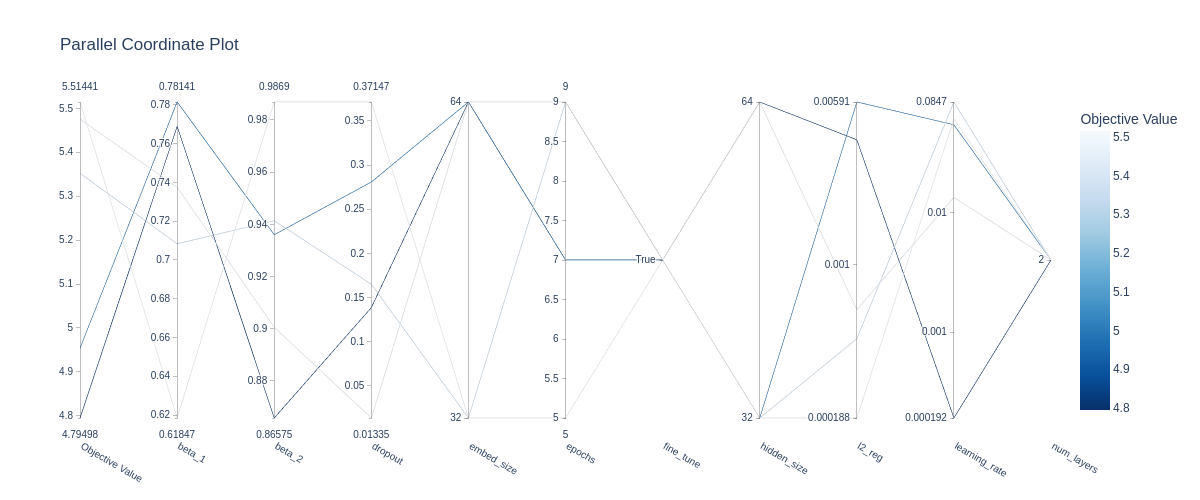

In [23]:
plot_hpo(optuna.visualization.plot_parallel_coordinate(study), height=500, width=1200)

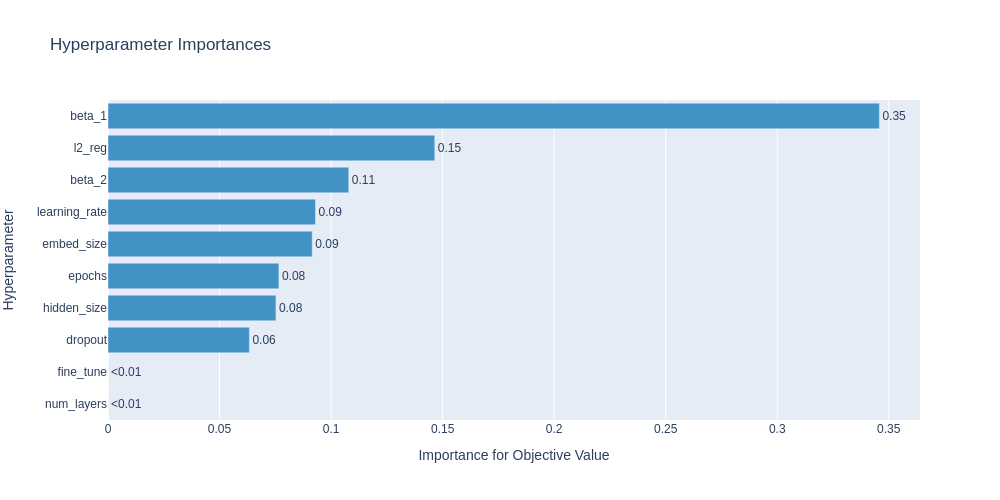

In [24]:
plot_hpo(optuna.visualization.plot_param_importances(study))

### Retrain with Best Hyperparameters

In [20]:
trainer = Trainer(
    hyperparameters=study.best_params,
    train={'loader': train_loader, 'dataset': train_dataset},
    val={'loader': val_loader, 'dataset': val_dataset},
    logger=logger,
    patience=3,
    min_delta=1e-3,
    restore_best_model=True
)

model, best_val_loss = trainer.train_model()

2023-08-07 02:09:52,074 INFO torch-cnn-lstm-hpo: Epoch 1/7, Training Loss: 4.6264, Validation Loss: 4.9385


INFO:torch-cnn-lstm-hpo:Epoch 1/7, Training Loss: 4.6264, Validation Loss: 4.9385


2023-08-07 02:09:52,116 INFO torch-cnn-lstm-hpo: Current Best Validation Loss at epoch 1: 4.9385


INFO:torch-cnn-lstm-hpo:Current Best Validation Loss at epoch 1: 4.9385


2023-08-07 02:12:40,449 INFO torch-cnn-lstm-hpo: Epoch 2/7, Training Loss: 4.2435, Validation Loss: 4.7763


INFO:torch-cnn-lstm-hpo:Epoch 2/7, Training Loss: 4.2435, Validation Loss: 4.7763


2023-08-07 02:12:40,499 INFO torch-cnn-lstm-hpo: Current Best Validation Loss at epoch 2: 4.7763


INFO:torch-cnn-lstm-hpo:Current Best Validation Loss at epoch 2: 4.7763


2023-08-07 02:15:32,329 INFO torch-cnn-lstm-hpo: Epoch 3/7, Training Loss: 4.0811, Validation Loss: 4.7975


INFO:torch-cnn-lstm-hpo:Epoch 3/7, Training Loss: 4.0811, Validation Loss: 4.7975


2023-08-07 02:18:24,234 INFO torch-cnn-lstm-hpo: Epoch 4/7, Training Loss: 4.1527, Validation Loss: 4.8162


INFO:torch-cnn-lstm-hpo:Epoch 4/7, Training Loss: 4.1527, Validation Loss: 4.8162


2023-08-07 02:21:14,777 INFO torch-cnn-lstm-hpo: Epoch 5/7, Training Loss: 4.0859, Validation Loss: 4.8395


INFO:torch-cnn-lstm-hpo:Epoch 5/7, Training Loss: 4.0859, Validation Loss: 4.8395


2023-08-07 02:21:14,780 INFO torch-cnn-lstm-hpo: Early stopping triggered at epoch 5, restoring best model weights


INFO:torch-cnn-lstm-hpo:Early stopping triggered at epoch 5, restoring best model weights


## Inference

In [55]:
def generate_and_plot_caption(model: CaptionModel, path: str, vocabulary: Any, transform: Callable, device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) -> None:
    """
    Generate a caption for the image at the given path and plot the image with its caption.

    Parameters
    ----------
    model : CaptionModel
        The trained captioning model.
    path : str
        Path to the image file.
    vocabulary : Any
        Vocabulary object with mapping between tokens and indices.
    transform : Callable
        Transformation pipeline to apply to the image.
    device : torch.device, default=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        Device to use for computations (either CUDA or CPU).
    """
    # Open the image and apply the transformation
    image = Image.open(path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)


    # Generate a caption for the image
    model.eval()
    caption = model.caption_image(image_tensor, vocabulary)
    caption_text = ' '.join(caption)

    # Plot the image and its caption
    plt.imshow(image)
    plt.title(caption_text)
    plt.axis('off')  # Hide axes
    plt.show()

Generate a list of 10 images from the test folder:

In [56]:
# Sample images
images = random.choices(os.listdir(os.path.join(data_path, 'images/test')), k=10)
images = [os.path.join(data_path, 'images/test', image) for image in images]

# Transformation
transform_pipeline = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])